In [1]:
# import os
import matplotlib.pyplot as plt
import os
import pandas as pd
from amftrack.util.sys import get_analysis_folders,get_time_plate_info_from_analysis,get_time_hypha_info_from_analysis,get_global_hypha_info_from_analysis 
import numpy as np
import imageio
import os
import cv2
from scipy.interpolate import interp1d
from scipy.optimize import curve_fit
from amftrack.pipeline.final_analysis.density_wave import get_wave_fit, S, dS, wave, dwave
import matplotlib.patches as mpatches
from random import choice
import matplotlib as mpl
from amftrack.pipeline.final_analysis.density_wave import plot_single_plate,plot_single_plate_biovolume
from amftrack.pipeline.final_analysis.hypha_speed_analysis import *
from amftrack.util.plot import gridplot, make_stat
from helper import *
from load_dataframes import load_all
from plates import plates,timestep
%matplotlib widget
%load_ext autoreload
%autoreload 2
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import scipy
import statsmodels.api as sm
import hashlib
from matplotlib.patches import Ellipse
import logging
plt.style.use('presentation.mplstyle')
import seaborn as sns
import matplotlib.pyplot as plt
logging.getLogger().setLevel(logging.WARNING)

c:\users\coren\documents\phd\code\amftrack\amftrack\util\dbx.py:3: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
path_figure = r"C:\Users\coren\Documents\PhD\paper\PandC\Fig2"


In [3]:
df,final_data = load_all(plates)

C:\Users\coren\Documents\PhD\Code\pycode\P_depletion_paper\final_figures\load_dataframes.py:111: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  df_sum['start'] = pd.to_datetime(df_sum['start'], errors='coerce')
C:\Users\coren\Documents\PhD\Code\pycode\P_depletion_paper\final_figures\load_dataframes.py:112: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  df_sum['crossed']  = pd.to_datetime(df_sum['crossed'], errors='coerce')
C:\Users\coren\Documents\PhD\Code\pycode\P_depletion_paper\final_figures\load_dataframes.py:113: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsi

In [4]:
def calculate_derivative(df, column, new_column, window=1):
    # Ensure the DataFrame is sorted by 'unique_id' and 'time_since_begin_h'
    df.sort_values(by=['unique_id', 'time_since_begin_h'], inplace=True)
    
    # Calculate the time difference and value difference over the desired window
    df['time_diff'] = df.groupby('unique_id')['time_since_begin_h'].transform(lambda x: x.diff(window)).fillna(0)
    df['value_diff'] = df.groupby('unique_id')[column].transform(lambda x: x.diff(window)).fillna(0)

    # Calculate the derivative (value difference divided by time difference)
    # Be cautious about dividing by zero. If 'time_diff' is 0, set derivative to NaN or handle accordingly.
    df[new_column] = df.apply(lambda x: x['value_diff'] / x['time_diff'] if x['time_diff'] != 0 else None, axis=1)

    # Drop the helper columns
    df.drop(['time_diff', 'value_diff'], axis=1, inplace=True)
def calculate_integral(df, column, new_column):
    # Calculate the time difference within each group
    df.sort_values(by=['unique_id', 'time_since_begin_h'], inplace=True)
    df['time_since_begin_hour'] = df['time_since_begin_h']
    df['time_diff'] = df.groupby('unique_id')['time_since_begin_hour'].transform(lambda x: x.diff())

    # Calculate the average length density within each group
    df['avg_length_density'] = df.groupby('unique_id')[column].transform(lambda x: x.rolling(window=2).mean())

    # Calculate the "area" (using Trapezoidal rule) for each pair of rows within each group
    df['area'] = df['time_diff'] * df['avg_length_density']

    # Perform the integration (cumulative sum of "area") within each group
    df[new_column] = df.groupby('unique_id')['area'].transform(lambda x: x.cumsum())

    # Drop the helper columns if needed
    df.drop(['time_diff', 'avg_length_density', 'area'], axis=1, inplace=True)
calculate_integral(final_data,f'tot_surface_area_study',f'integrated_SA')
calculate_derivative(final_data,f'tot_biovolume_study',f'derivative_biovolume', window=5)
calculate_derivative(final_data,f'tot_volume',f'derivative_tot_biovolume', window=5)
calculate_derivative(final_data,f'tot_biovolume_study',f'derivative_biovolume_smooth', window=10)


Vmax = 3e-9*25 #ugP/um2/hour
density = 1e-6 #ug/um3
dry_wet_ratio = 0.3
carbon_ratio = 0.5
carbon_ratio_spore = 0.9
dry_wet_ratio_spore = 0.9
density_spore = 0.9e-6
respiration_ratio = 0.5
final_data['P_rate'] =final_data['tot_surface_area_study']*Vmax
final_data['C_rate'] = final_data['derivative_biovolume']*density*dry_wet_ratio*carbon_ratio/respiration_ratio
final_data['totC_hypha'] = final_data['tot_biovolume_study']*density*dry_wet_ratio*carbon_ratio
final_data['tot_volume'] = final_data['spore_volume']+final_data['tot_biovolume_study']
final_data['totC_spore'] = final_data['spore_volume']*density_spore*dry_wet_ratio_spore*carbon_ratio_spore
final_data['totC_tot'] = final_data['totC_hypha'] + final_data['totC_spore']

final_data = final_data.reset_index(drop=True)
final_data_select = final_data.loc[final_data['time_since_begin_h_shifted']<=150]

max_c_rate_time = final_data_select.loc[final_data_select.groupby('unique_id')['C_rate'].idxmax(), ['unique_id', 'time_since_begin_h_shifted']]

# Step 2: Merge this information back to the original DataFrame
final_data = final_data.merge(max_c_rate_time, on='unique_id', suffixes=('', '_max_c_rate'))

<AxesSubplot: xlabel='time_since_begin_h_shifted', ylabel='hull_speed'>

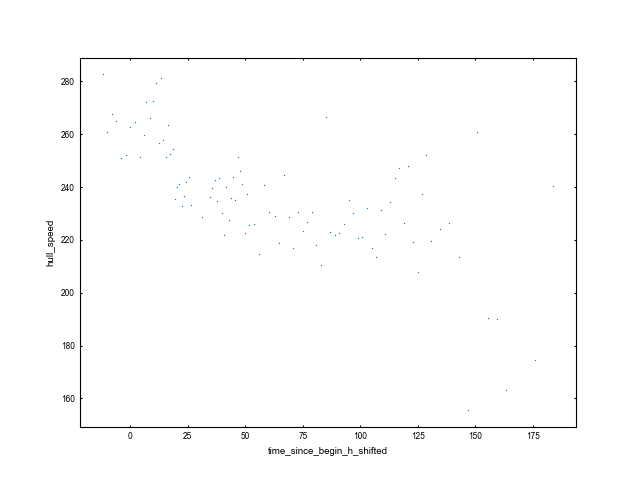

In [5]:
select = final_data[final_data['unique_id'] == 84_20220621]
select = select[select['time_since_begin_h_shifted'] <= 200]

fig,ax = plt.subplots()
sns.scatterplot(data=select, x='time_since_begin_h_shifted', y='hull_speed', ax=ax, lw=1)
# ax.vlines(select['time_since_begin_h_shifted_max_c_rate'].iloc[0],0,1e6,color= "red")

In [6]:
calculate_derivative(final_data,f'tot_surface_area_study',f'derivative_SA', window=5)
calculate_derivative(final_data,f'totC_tot',f'derivative_C', window=5)

calculate_derivative(final_data,f'area_sep_comp',f'derivative_area', window=5)
final_data['instant_SA_dens'] = final_data['derivative_SA']/final_data['derivative_area']
calculate_derivative(final_data,f'tot_biovolume_study',f'derivative_BV', window=5)
final_data['instant_BV_dens'] = final_data['derivative_BV']/final_data['derivative_area']
calculate_derivative(final_data,f'tot_length_study',f'derivative_L', window=5)
final_data['instant_L_dens'] = final_data['derivative_L']/final_data['derivative_area']
final_data['instant_C_dens'] = final_data['derivative_C']/final_data['derivative_area']

final_data['instant_radius'] = final_data['instant_BV_dens']/final_data['instant_SA_dens']*2


In [7]:
df['FungalSide'] = df['FungalSide'].fillna("100P/100N/100C")
df['FungalSide'] = df['FungalSide'].replace("100P100N100C","100P/100N/100C")
df['FungalSide'] = df['FungalSide'].replace("100P100N100C","100P/100N/100C")

df['treatment'] = df['treatment'].replace("1P100N100C","1P/100N/100C")
df['fungus'] = df['fungus'].replace("A5sp3","A5")
df['category_combination'] = df[['treatment', 'FungalSide',"real_root"]].apply(lambda x: '_'.join(x.astype(str)), axis=1)
df['size_point'] = 20
marker_symbols = {
    "C2": 'circle',
    "A5": 'square',
    "Agg": 'diamond',
    "Clarum": 'cross',
    "C3": 'star',
    
    
    # Add more mappings as needed
}

n_colors = len(df['fungus'].unique())

palette = sns.color_palette("rainbow", n_colors)
strain_to_color = dict(zip(df['fungus'].unique(), palette))
df['full_category_combination'] = df[['fungus','treatment', 'FungalSide',"real_root"]].apply(lambda x: '_'.join(x.astype(str)), axis=1)

# Map the strain to the marker symbol in the DataFrame
df['marker'] = df['fungus'].map(marker_symbols)


In [8]:
df.groupby('fungus').count()

,plate_id,start_x,speed,density_SA,density_BV,density_L,radius,radius_SA,strain,fungalC,...,Analysis priority,Running,Suitable for spores,real_root,date_fungus,age,category_combination,size_point,full_category_combination,marker
fungus,,,,,,,,,,,,,,,,,,,,,
A5,14,14,13,13,13,13,13,13,14,14,...,0,0,1,14,13,14,14,14,14,14
Agg,4,4,4,4,4,4,4,4,4,4,...,3,4,3,4,4,4,4,4,4,4
C2,58,58,39,42,42,42,42,42,58,58,...,0,1,2,58,41,58,58,58,58,58
C3,4,4,4,4,4,4,4,4,4,4,...,4,2,4,4,4,4,4,4,4,4
Clarum,6,6,4,4,4,4,4,4,6,6,...,6,4,6,6,6,6,6,6,6,6


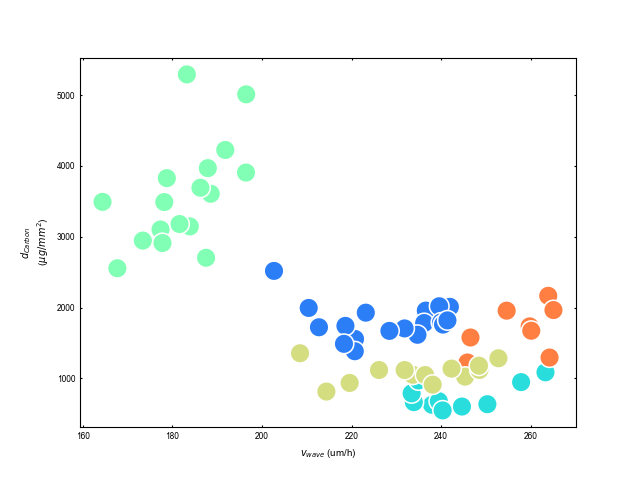

In [9]:
bin_size = 30
cm = 1/2.54  # centimeters in inches
select = final_data
select = final_data.loc[final_data['hull_speed']>0].copy()
select['hull_speed_binned'] = select['hull_speed'].astype(int)//bin_size*bin_size
select= select[select['instant_C_dens']>0]
select= select[select['instant_C_dens']<=0.025]
select= select[select['real_root']=="Carrot Toby"]
# select= select[select['strain']=="C2"]
select = select[select['time_since_begin_h_shifted'] < select['time_since_begin_h_shifted_max_c_rate']+20]
# select = select[select['time_hour_binned'] <= 50]
# select = select[select['time_hour_binned'] >= 0]

summary = select.groupby(["strain", 'time_hour_binned']).agg({
    'hull_speed': 'median',
    'instant_SA_dens': 'median',
    'radius': 'median',
    'instant_BV_dens': 'count',
    'instant_L_dens': 'median',
    'instant_C_dens': 'median',
    
}).rename(columns={'instant_BV_dens': 'count'})
summary = summary[summary['count']>7]
summary = summary.reset_index()
fig,ax = plt.subplots()

sns.scatterplot(summary, x='hull_speed', y='instant_L_dens',hue="strain",s=50,palette=strain_to_color,alpha = 0.4)
# sns.regplot(data=summary, x='hull_speed', y='instant_L_dens',scatter = False,color = "black")
# summary = select.groupby("strain")[['hull_speed','hull_speed_binned','instant_SA_dens','radius','instant_BV_dens','instant_L_dens','instant_C_dens']].median()
sns.scatterplot(summary, x='hull_speed', y='instant_L_dens',hue="strain",s=200,palette=strain_to_color)
ax.legend('')
summary['size_point'] = 20
summary['fungus'] = summary.index
ax.set_xlabel('$v_{wave}$ (um/h)')
ax.set_ylabel('$d_{Carbon}$ \n ($\mu g/mm^2$)')
plt.legend().remove()
# plt.tight_layout()

# plt.savefig(os.path.join(path_figure,'Figure2A.pdf'), transparent=True, bbox_inches='tight')


In [10]:
summary[['hull_speed','instant_L_dens','strain']].to_csv('expexptradeoff.csv')

2024-01-31 11:23:24,307-[WARNING]- fontTools.subset:2983 -> meta NOT subset; don't know how to subset; dropped


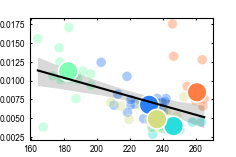

In [11]:
bin_size = 30
cm = 1/2.54  # centimeters in inches
select = final_data
select = final_data.loc[final_data['hull_speed']>0].copy()
select['hull_speed_binned'] = select['hull_speed'].astype(int)//bin_size*bin_size
select= select[select['instant_C_dens']>0]
select= select[select['instant_C_dens']<=0.025]
select= select[select['real_root']=="Carrot Toby"]
# select= select[select['strain']=="C2"]
select = select[select['time_since_begin_h_shifted'] < select['time_since_begin_h_shifted_max_c_rate']+20]
# select = select[select['time_hour_binned'] <= 50]
# select = select[select['time_hour_binned'] >= 0]

summary = select.groupby(["strain", 'time_hour_binned']).agg({
    'hull_speed': 'median',
    'instant_SA_dens': 'median',
    'radius': 'median',
    'instant_BV_dens': 'count',
    'instant_L_dens': 'median',
    'instant_C_dens': 'median',
    
}).rename(columns={'instant_BV_dens': 'count'})
summary = summary[summary['count']>7]
summary = summary.reset_index()
fig,ax = plt.subplots(figsize = (6*cm,4*cm))

sns.scatterplot(summary, x='hull_speed', y='instant_C_dens',hue="strain",s=50,palette=strain_to_color,alpha = 0.4)
sns.regplot(data=summary, x='hull_speed', y='instant_C_dens',scatter = False,color = "black")
summary = select.groupby("strain")[['hull_speed','hull_speed_binned','instant_SA_dens','radius','instant_BV_dens','instant_L_dens','instant_C_dens']].median()
sns.scatterplot(summary, x='hull_speed', y='instant_C_dens',hue="strain",s=200,palette=strain_to_color)
ax.legend('')
summary['size_point'] = 20
summary['fungus'] = summary.index
ax.set_xlabel('$v_{wave}$ (um/h)')
ax.set_ylabel('$d_{Carbon}$ \n ($\mu g/mm^2$)')
plt.legend().remove()
# plt.tight_layout()

plt.savefig(os.path.join(path_figure,'Figure2A.pdf'), transparent=True, bbox_inches='tight')


In [12]:
select = final_data[final_data['real_root']=="Carrot Toby"]
select = select[select['time_since_begin_h_shifted'] < select['time_since_begin_h_shifted_max_c_rate']+20]
select = select[select['C_rate'] >= 0]
max_c_rate_time = select.loc[select.groupby('unique_id')['time_since_begin_h_shifted'].idxmax(), ['folder','unique_id','time_since_begin_h']]
max_c_rate_time.to_csv('list_last_folder.csv')

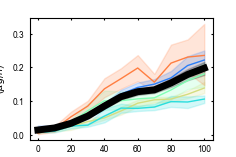

In [13]:
import os
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming final_data is your DataFrame and it contains a 'unique_id' column
# Group by 'time_hour_binned' and filter out groups with less than 3 unique IDs
tmax = 150
select = final_data[final_data['real_root']=="Carrot Toby"]
select = select[select['time_since_begin_h_shifted'] < select['time_since_begin_h_shifted_max_c_rate']+20]
select = select[select['time_hour_binned'] <= 50]
select = select[select['C_rate'] >= 0]
select = select.copy()
select['time_reshift'] = select['time_hour_binned']+50



grouped = select.groupby('time_hour_binned')
filtered_groups = grouped.filter(lambda x: x['unique_id'].nunique() >= 7)

# Now, use this filtered data for your plots
fig,ax = plt.subplots(figsize = (6*cm,4*cm))
sns.lineplot(data=filtered_groups, x='time_reshift', y='C_rate', hue='strain', ax=ax, palette=strain_to_color, lw=1)

# Mean line plot
sns.lineplot(data=filtered_groups, x='time_reshift', y='C_rate', ax=ax, color='black', estimator='mean', lw=5, ls="-")

ax.set_xlabel('t-t* (hour)')
ax.set_ylabel('$\Phi_C$ \n ($\mu g/h$)')
# ax.set_ylim(0)
plt.legend().remove()
# plt.tight_layout()
# Save the figure
# plt.savefig(os.path.join(path_figure, 'Figure2B.pdf'), transparent=True, bbox_inches='tight')


In [14]:
max_c_rate_time

,folder,unique_id,time_since_begin_h
133,20220509_1609_Plate16,3.202204e+08,309.166667
271,20220510_1640_Plate13,1.220221e+09,185.183333
399,20220423_1940_Plate10,1.620220e+09,95.183333
548,20230305_1310_Plate06,2.820230e+09,140.100000
677,20220714_1619_Plate07,5.220221e+09,169.350000
824,20220622_2245_Plate01,8.420221e+09,31.400000
1046,20220714_1248_Plate09,9.120221e+09,142.916667
1178,20230321_0904_Plate07,2.022023e+10,159.050000
1347,20230311_1240_Plate11,2.192023e+10,93.300000
1448,20230404_1004_Plate12,2.292023e+10,114.183333


2024-01-31 11:23:33,417-[WARNING]- fontTools.subset:2983 -> meta NOT subset; don't know how to subset; dropped


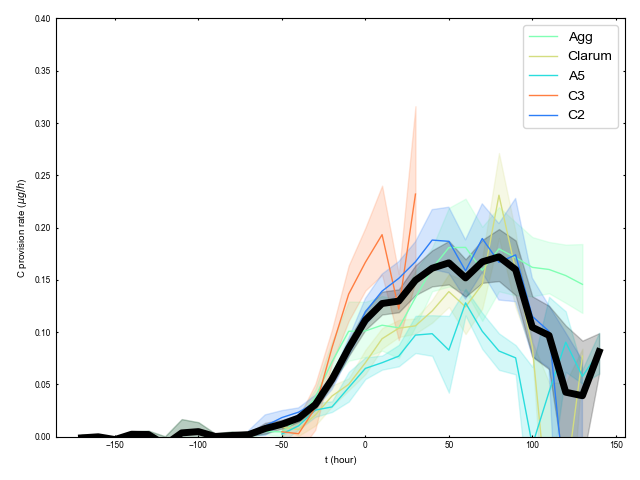

In [15]:
fig,ax = plt.subplots()
n_colors = len(final_data['strain'].unique())

tmax = 150
select = final_data[final_data['real_root']=="Carrot Toby"]
select = select[select['time_since_begin_h_shifted'] < select['time_since_begin_h_shifted_max_c_rate']]

sns.lineplot(data=select, x='time_hour_binned', y=select['C_rate'], hue='strain',ax=ax, palette=strain_to_color,lw = 1)
sns.lineplot(data=select, x='time_hour_binned', y=select['C_rate'], ax=ax, color = 'black', estimator='mean', lw=5, ls="-")

# ax.legend().remove()
ax.set_xlabel('t (hour)')
ax.set_ylabel('BV ($\mu m^3$)')
ax.set_ylim(0,0.4)
ax.set_ylabel('C provision rate ($\mu g/h$)')
ax.set_xlabel('t (hour)')
# ax.set_xlim(-40,100)
plt.tight_layout()
plt.savefig(os.path.join(path_figure,'Figure2B.pdf'), transparent=True, bbox_inches='tight')


In [18]:
strain_to_color

{'C2': (0.17058823529411765, 0.4946558433997788, 0.9667184042691874),
 'A5': (0.16666666666666663, 0.8660254037844386, 0.8660254037844387),
 'Agg': (0.503921568627451, 0.9999810273487268, 0.7049255469061472),
 'Clarum': (0.8333333333333333, 0.8660254037844387, 0.5000000000000001),
 'C3': (1.0, 0.4946558433997788, 0.2558427775944356)}

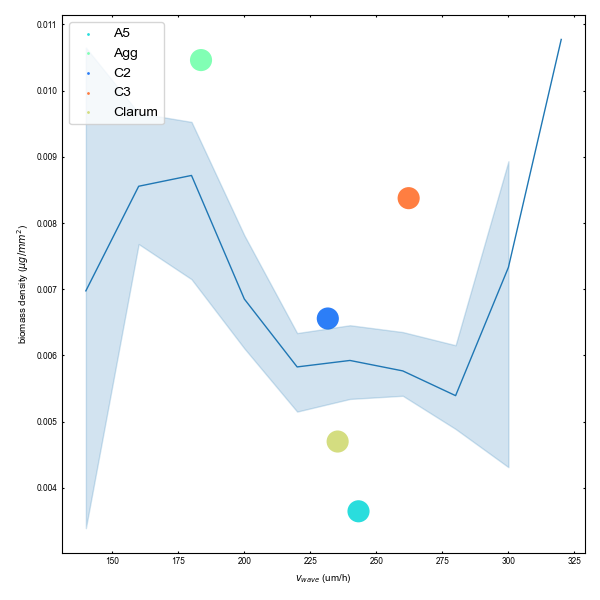

In [16]:
bin_size = 20

select = final_data
select = final_data.loc[final_data['hull_speed']>0].copy()
select['hull_speed_binned'] = select['hull_speed'].astype(int)//bin_size*bin_size

# select= final_data[final_data['real_root']=="Carrot Toby"]
select= select[select['real_root']=="Carrot Toby"]
# select= select[select['strain']=="C2"]
select = select[select['time_since_begin_h_shifted'] < select['time_since_begin_h_shifted_max_c_rate']]

# select= select[select['time_hour_binned']<=160]
select= select[select['instant_C_dens']<=0.02]
select= select[select['instant_C_dens']>0]
# select= select[select['time_hour_binned']>=20]
summary = select.groupby("strain")[['hull_speed','hull_speed_binned','instant_SA_dens','radius','instant_BV_dens','instant_L_dens','instant_C_dens']].median()

summary['size_point'] = 20
summary['fungus'] = summary.index


fig,ax = plt.subplots(figsize = (6,6))


# sns.scatterplot(select, x='hull_speed', y='instant_C_dens',hue="strain",s=5,legend = False,palette=strain_to_color)
sns.scatterplot(summary, x='hull_speed', y='instant_C_dens',hue="strain",s=300,palette=strain_to_color)
# select = select.loc[select['hull_speed']<320]
# select = select.loc[select['hull_speed']>160]
select= select[select['instant_C_dens']<=0.02]

# sns.regplot(select, x='hull_speed', y='instant_C_dens',scatter = False)

sns.lineplot(select, x='hull_speed_binned', y='instant_C_dens',estimator = "median")
ax.set_xlabel('$v_{wave}$ (um/h)')
ax.set_ylabel(r'biomass density ($\mu g/mm^2$)')

plt.tight_layout()


In [17]:
z

NameError: name 'z' is not defined

In [ ]:
bin_size = 30

select = final_data
select = final_data.loc[final_data['hull_speed']>0].copy()
select['hull_speed_binned'] = select['hull_speed'].astype(int)//bin_size*bin_size
select= select[select['instant_C_dens']>0]
select= select[select['instant_C_dens']<=0.06]
select= select[select['time_hour_binned']>=50]

summary = select.groupby(["strain", 'hull_speed_binned']).agg({
    'hull_speed': 'median',
    'instant_SA_dens': 'median',
    'radius': 'median',
    'instant_BV_dens': 'median',
    'instant_L_dens': 'median',
    'instant_C_dens': 'median',
    'hull_speed': 'count'  # This will count the number of rows in each group
}).rename(columns={'hull_speed': 'count'})
summary = summary[summary['count']>30]
summary = summary.reset_index()

fig,ax = plt.subplots(figsize = (6,6))
sns.scatterplot(summary, x='hull_speed_binned', y='instant_C_dens',hue="strain",s=300,palette=strain_to_color)
sns.regplot(data=summary, x='hull_speed_binned', y='instant_C_dens',scatter = False)



In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.utils import resample

bin_size = 20

select = final_data
select = final_data.loc[final_data['hull_speed']>0].copy()
select['hull_speed_binned'] = select['hull_speed'].astype(int)//bin_size*bin_size
counts = select.groupby('strain')['strain'].transform('count')

# Calculate the weight as the reciprocal of the count
select['weight'] = 1 / counts

# select= final_data[final_data['real_root']=="Carrot Toby"]
select= select[select['real_root']=="Carrot Toby"]
# select= select[select['strain']=="C2"]
select = select[select['time_since_begin_h_shifted'] < select['time_since_begin_h_shifted_max_c_rate']]

# select= select[select['time_hour_binned']<=160]
select= select[select['instant_C_dens']<=0.03]
select= select[select['instant_C_dens']>0]
# select= select[select['time_hour_binned']>=50]
summary = select.groupby("strain")[['hull_speed','hull_speed_binned','instant_SA_dens','radius','instant_BV_dens','instant_L_dens','instant_C_dens']].median()

summary['size_point'] = 20
summary['fungus'] = summary.index
# Bootstrapping parameters
n_bootstraps = 10
bootstrapped_medians = {strain: {'hull_speed': [], 'instant_C_dens': []} for strain in select['strain'].unique()}

# Perform Bootstrapping
for _ in range(n_bootstraps):
    for strain, group in select.groupby('strain'):
        sample = group.sample(n=len(group), replace=True)  # Bootstrap sample
        bootstrapped_medians[strain]['hull_speed'].append(sample['hull_speed'].median())
        bootstrapped_medians[strain]['instant_C_dens'].append(sample['instant_C_dens'].median())

# Calculate errors (standard deviation of the bootstrapped medians)
errors = {strain: {'hull_speed': np.std(bootstrapped_medians[strain]['hull_speed']),
                   'instant_C_dens': np.std(bootstrapped_medians[strain]['instant_C_dens'])}
          for strain in bootstrapped_medians}

# Plotting
fig, ax = plt.subplots(figsize=(6, 6))

for strain, color in strain_to_color.items():
    strain_data = summary.loc[summary['fungus'] == strain]
    ax.errorbar(strain_data['hull_speed'], strain_data['instant_C_dens'],
                xerr=errors[strain]['hull_speed'], yerr=errors[strain]['instant_C_dens'],
                fmt='o', color=color, label=strain, markersize=10)


sns.regplot(summary, x='hull_speed', y='instant_C_dens',scatter = False,ci=None)
select= select[select['instant_C_dens']<=0.05]

# sns.scatterplot(select, x='hull_speed', y='instant_C_dens',hue="strain",s=5,legend = False,palette=strain_to_color,alpha = 0.2)
# sns.regplot(select, x='hull_speed', y='instant_C_dens',scatter = False)

ax.set_xlabel('$v_{wave}$ (um/h)')
ax.set_ylabel(r'biomass density ($\mu g/mm^2$)')
ax.set_ylim
ax.legend()

plt.tight_layout()
plt.show()


In [ ]:
fig, ax = plt.subplots()

select = final_data
# select= final_data[final_data['real_root']=="Carrot Toby"]
select= select[select['real_root']=="Carrot Toby"]
# select= select[select['strain']=="C2"]
select= select[select['time_hour_binned']<=160]
select= select[select['instant_C_dens']>0]
select= select[select['instant_C_dens']<=0.03]
select= select[select['time_hour_binned']>=-40]




# sns.scatterplot(data=select,x='time_since_begin_h_shifted',y='tot_surface_area_study',size = 5,alpha = 0.3,legend=False,color="grey")

sns.lineplot(data=select,x='time_hour_binned',y='instant_BV_dens',hue = "strain",estimator = "median",palette=strain_to_color)
ax.set_ylabel('Instant biovolume density \n ($\mu m^3/mm^2$)')
ax.set_xlabel('time (hour)')
# ax.set_ylim(0,60000)
plt.tight_layout()


In [ ]:
fig, ax = plt.subplots()

select = final_data
# select= final_data[final_data['real_root']=="Carrot Toby"]
select= select[select['real_root']=="Carrot Toby"]
# select= select[select['strain']=="C2"]
select= select[select['time_hour_binned']<=160]
select= select[select['instant_C_dens']>0]
select= select[select['instant_C_dens']<=0.03]
select= select[select['time_hour_binned']>=-40]




# sns.scatterplot(data=select,x='time_since_begin_h_shifted',y='tot_surface_area_study',size = 5,alpha = 0.3,legend=False,color="grey")

sns.lineplot(data=select,x='time_hour_binned',y='hull_speed',hue = "strain",estimator = "median",palette=strain_to_color)
ax.set_ylabel('Instant biovolume density \n ($\mu m^3/mm^2$)')
ax.set_xlabel('time (hour)')
# ax.set_ylim(0,60000)
plt.tight_layout()


In [ ]:
fig, ax = plt.subplots()

select = final_data
# select= final_data[final_data['real_root']=="Carrot Toby"]
select= select[select['real_root']=="Carrot Toby"]
# select= select[select['strain']=="C2"]
select= select[select['time_hour_binned']<=160]
select= select[select['instant_SA_dens']<=8e4]
select= select[select['instant_SA_dens']>0]
select= select[select['time_hour_binned']>=-40]




# sns.scatterplot(data=select,x='time_since_begin_h_shifted',y='tot_surface_area_study',size = 5,alpha = 0.3,legend=False,color="grey")

sns.lineplot(data=select,x='time_hour_binned',y='hull_speed',hue = "strain",estimator = "median",palette=strain_to_color)
ax.set_ylabel('Instant biovolume density \n ($\mu m^3/mm^2$)')
ax.set_xlabel('time (hour)')
# ax.set_ylim(0,60000)
plt.tight_layout()


In [ ]:
selectd= select[select['strain']=="C3"]
len(selectd)